Wilson's personal notebook

Metric: Transportation

Neighborhood borders: https://data.wprdc.org/dataset/neighborhoods2
Transit stop locations: https://data.wprdc.org/dataset/port-authority-of-allegheny-county-transit-stops

In [1]:
# import libraries
import geopandas as gpd
import pandas as pd
from scipy import stats

In [2]:
# read neighborhood polygons
neighborhoods = gpd.read_file('https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson')

# Reproject hoods to match CRS with meters as base (so I can calculate per-km)
neighborhoods = neighborhoods.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

neighborhoods.head()

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,page_number,plannerassign,created_user,created_date,last_edited_user,last_edited_date,temp,Shape__Area,Shape__Length,geometry
0,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.068796e+07,19600.573085,"POLYGON ((-3795.920 4118843.009, -3785.567 411..."
1,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.133208e+07,21174.473326,"POLYGON ((-1657.274 4122282.602, -1651.679 412..."
2,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,8.743618e+06,13811.917169,"POLYGON ((-821.954 4120841.104, -820.083 41208..."
3,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.754935e+07,18197.745741,"POLYGON ((-192.173 4120155.314, -191.926 41201..."
4,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,2.522420e+07,26390.549314,"POLYGON ((-2040.634 4120396.643, -2055.439 412..."


In [3]:
# create hood buffers (expand the neighborhoods by 200m each since that better represents transit accessibility)
hoods_buffer = neighborhoods.assign(
  old_geom = neighborhoods['geometry'],
  geometry = lambda df: df['geometry'].map(lambda geom: geom.buffer(200))
).assign(
  buffer_area = lambda df: df['geometry'].map(lambda geom: geom.area)
)

In [4]:
# read bus stop points
stops = gpd.read_file('./wbiggs-data/paac_stops_1909/PAAC_Stops_1909.dbf')

# Reproject stops to match CRS with meters as base
stops = stops.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

#stops.head()

In [5]:
# Count stops per neighborhood
stops_hoods_join = gpd.sjoin(stops, hoods_buffer)

hoods_points = hoods_buffer.join(stops_hoods_join.groupby('index_right').size().rename('points'),how='left')

hoods_points['points'] = hoods_points['points'].fillna(0)

# Calculate density
hoods_points['count_per_sq_km'] = hoods_points['points'] / (hoods_points['buffer_area'] / 1000000)

hoods_points['buf_geom'] = hoods_points['geometry']
hoods_points['geometry'] = hoods_points['old_geom']

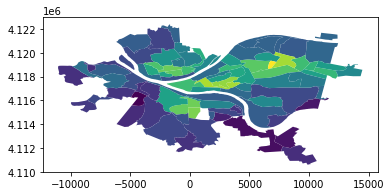

In [6]:
hoods_points.plot(column='count_per_sq_km')

In [7]:
# I want scores to be evenly distributed - "50" should be about average - so I'm going to transform this to a uniform density distribution
import seaborn as sns
import numpy as np

print(sns.__version__)

0.11.2


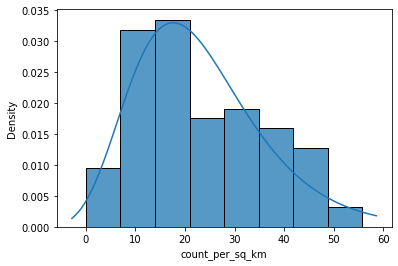

In [8]:
s, loc, scale = stats.lognorm.fit(hoods_points['count_per_sq_km'])

countplot = sns.histplot(hoods_points['count_per_sq_km'], stat='density')

space = np.linspace(*countplot.get_xlim(),100)
countplot.plot(space, stats.lognorm.pdf(space, s, loc, scale))

[]

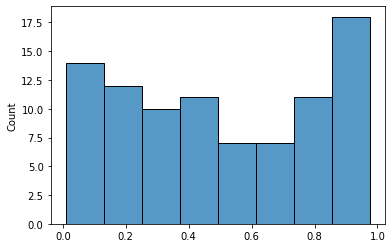

In [9]:
transformed = stats.lognorm.cdf(hoods_points['count_per_sq_km'], s, loc, scale)

# It's now roughly more uniform
transformedplot = sns.histplot(transformed)
transformedplot.plot()

In [11]:
# since we want max to be 100
hoods_points['transit_score'] = transformed / transformed.max()

pd.set_option('display.max_rows', None)

hoods_points = hoods_points.sort_values('transit_score', ascending = False)

hoods_points[['hood', 'transit_score']]

,hood,transit_score
29,Friendship,1.000000
39,Crawford-Roberts,0.976483
35,East Liberty,0.973481
38,West Oakland,0.972779
45,Terrace Village,0.964069
70,Knoxville,0.951457
62,Allentown,0.942426
6,Central Northside,0.940948
60,Beltzhoover,0.935131
13,Allegheny Center,0.930201


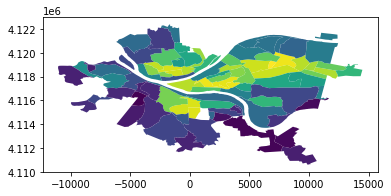

In [12]:
hoods_points.plot(column='transit_score')